# Clasificación binaria

El siguiente problema a resolver consiste en separar dos clases $Y = \{-1, +1\}$ utilizando redes neuronales. 

Las aplicaciones los cuales se podría aplicar este método de solución son:
1. Detección de spam.
2. Predecir si un paciente tiene una determinada enfermedad según los síntomas que presenta.

Como primer ejemplo se tiene un conjunto de datos que forman dos círculos concéntricos con algo de ruido, el objetivo es predecir a que clase pertenece un dato según las características que este tenga.

In [13]:
# Importando librerías
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as co
from sklearn.datasets import make_circles


$X\subset \mathbb R^d$, donde $d=2$ características para una mejor visualización y $Y=\{-1, 1\}$

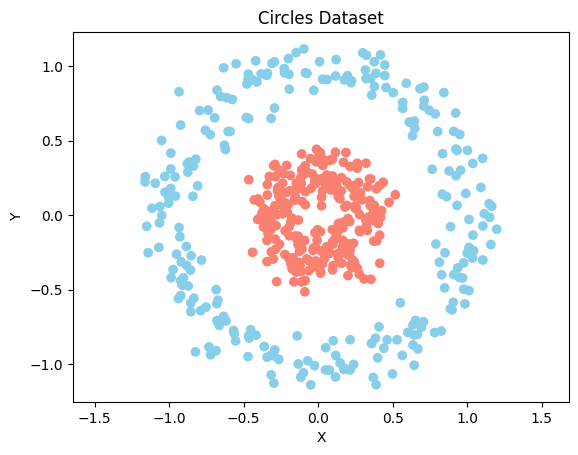

In [14]:
# Dataset
n = 500  # number of logs
p = 2   # number of characteristics 2, ex: name and height
X, Y = make_circles(n_samples=n, factor=0.3, noise=0.1)
Y = Y.reshape(-1, 1)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=co.ListedColormap(['skyblue', 'salmon']))

plt.title("Circles Dataset")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()


### Red Neuronal con una sola capa oculta

Los pesos $a_{ij}$ y $b_k$ son inicializados con valores aleatorios y $\mathbf x=(x^{(1)}, x^{(2)}, \dots, x^{(d)})$ es el vector con d características. La capa $l$, la neurona $i$ tiene la siguiente función lineal.

$$c_i = b_i + x^{(1)}a_{i1} + x^{(2)}a_{i2} + \dots + x^{(d)}a_{id} = b_i + \sum_{j=1}^da_{ij}x^{(j)}$$

A su vez a cada $c_i$ se le aplica una función $\sigma(z)$ llamada función de activación, el cual se desea que sea creciente y $\lim_{z→+\infty}\sigma(z) = 1$ y $\lim_{z→-\infty}\sigma(z) = 0$ para realizar la clasificación binaria. Para nuestro caso se está utilizando la función logística o sigmoide 

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Si nuestros datos estan en el rango $\{0, 1\}$ en vez de $\{-1, 1\}$, se realiza lo siguiente $\sigma(z) = 2\sigma(z) - 1$

La salida de cada capa $c_i$ es utilizando como entrada para la siguiente, en el caso de tener una sola capa oculta, la siguiente es la capa de salida. Teniendo así: 

$$\hat y_i = \sigma\left(c_0 + \sum_{j=1}^kp_{ij}c^{(j)}\right)$$


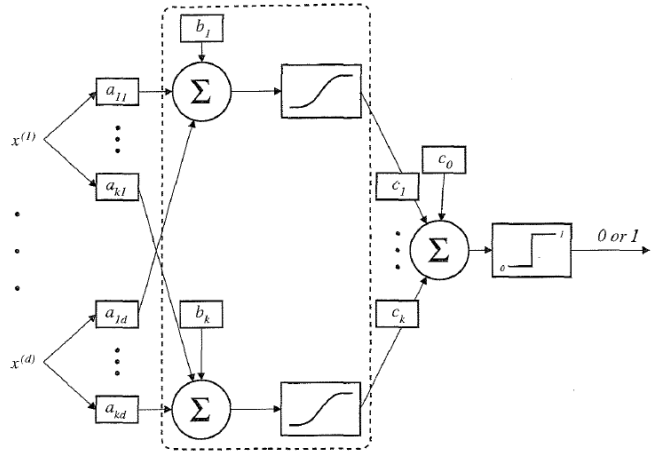

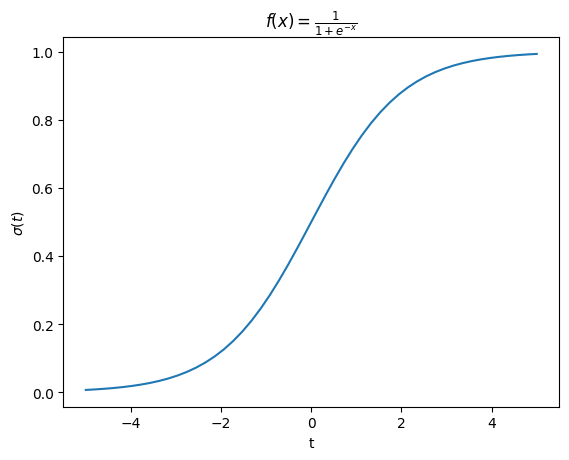

In [15]:
# clase capa
class Layer():
    def __init__(self, input_size: int, output_size: int, activation) -> None:
        self.activation = activation
        self.b = np.random.uniform(-1, 1, (1, output_size))
        self.A = np.random.uniform(-1, 1, (input_size, output_size))


# ACTIVATION FUNCTION
sigmoid = (lambda x: 1 / (1 + np.exp(-x)),
           lambda y: y * (1 - y))

heaviside = lambda x: 0 if x < 0 else 1

interval = np.linspace(-5, 5)
plt.plot(interval, sigmoid[0](interval))
plt.title(r"$f(x) = \frac{1}{1 + e^{-x}}$")
plt.xlabel("t")
plt.ylabel("$\sigma(t)$")
plt.plot()
plt.show()


In [16]:
def NeuralNetwork(topology, activation):
    # Agrega capas según la topologia dada 
    nn: list[Layer] = []
    for i in range(len(topology[:-1])):
        nn.append(Layer(topology[i], topology[i + 1], activation))
    return nn


In [17]:
topology_1 = [p, 4, 1]

neural_net = NeuralNetwork(topology_1, sigmoid)


A la salida $\hat y$ se le comparará con el resultado esperado $y$, luego con ello se calcula el error cuadrático medio

$$C(W) = \min_W \frac{1}{2}{\|\hat y - y\|}^2$$

Donde $W$ son todos los coefiecientes mostrados anteriormente e iniciados de forma aleatoria. Esto nos servirá para hallar todos los coeficientes de la red neuronal mediante el método del descenso de gradiente utilizando backpropagation

In [18]:
l2_cost = (lambda Y_pred, Y_real: 0.5 * np.mean((Y_pred - Y_real)**2),
           lambda Y_pred, Y_real: Y_pred - Y_real)

Derivadas parciales respecto los pesos en la capa de salida

\begin{align*}
\frac{\partial C}{\partial a^L} &= \frac{\partial C}{\partial \hat y} \frac{\partial \hat y}{\partial z^L} \frac{\partial z^L}{\partial a^L}\\
\frac{\partial C}{\partial b^L} &= \frac{\partial C}{\partial \hat y} \frac{\partial \hat y}{\partial z^L} \frac{\partial z^L}{\partial b^L} 
\end{align*}

Derivadas parciales respecto los pesos en la capa oculta

\begin{align*}
\frac{\partial C}{\partial a^{L-1}} &= \frac{\partial C}{\partial \hat y} \frac{\partial \hat y}{\partial z^L}  \frac{\partial z^L}{\partial a^{L-1}} \frac{\partial a^{L-1}}{\partial z^{L-1}} \frac{\partial z^{L-1}}{\partial w^{L-1}}\\
\frac{\partial C}{\partial b^{L-1}} &= \frac{\partial C}{\partial \hat y} \frac{\partial \hat y}{\partial z^L} \frac{\partial z^L}{\partial a^{L-1}} \frac{\partial a^{L-1}}{\partial z^{L-1}} \frac{\partial z^{L-1}}{\partial b^{L-1}}
\end{align*}


In [19]:
def train(neural_net: list[Layer], X: np.ndarray, Y: np.ndarray, l2_cost, lr=0.5, train=True):
    out = [(None, X)]
    # forward pass
    for i in range(len(neural_net)):
        z = out[-1][1] @ neural_net[i].A + neural_net[i].b
        a = neural_net[i].activation[0](z)
        out.append((z, a))
    
    if train:
        deltas = []
        for i in reversed(range(0, len(neural_net))):
            z = out[i + 1][0]
            a = out[i + 1][1]
            if i == len(neural_net) - 1:  # ultima capa
                # calcular delta ultima capa
                deltas.insert(0, l2_cost[1](a, Y) * neural_net[i].activation[1](a))  # al contrario de append lo pone al comienzo
            else:
                # calcular delta respecto a capa previa
                deltas.insert(0, deltas[0] @ _A.T * neural_net[i].activation[1](a))
            _A = neural_net[i].A
            # gradient descent
            neural_net[i].b = neural_net[i].b - np.mean(deltas[0], axis=0, keepdims=True) * lr
            neural_net[i].A = neural_net[i].A - out[i][1].T @ deltas[0] * lr
    return out[-1][1]


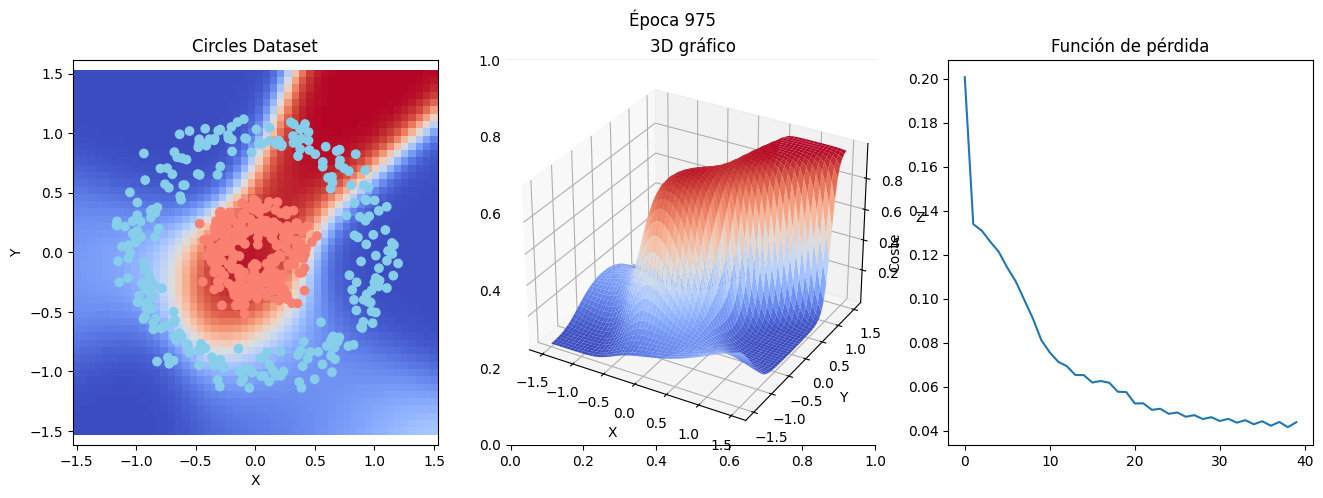

In [20]:
import time
from IPython.display import clear_output

neural_n = NeuralNetwork(topology_1, sigmoid)

loss = []
for i in range(1000):
    # entrenamos a la la red
    pY = train(neural_n, X, Y, l2_cost, lr=0.05)
    if i % 25 == 0:
        loss.append(l2_cost[0](pY, Y))

        res = 50
        # malla de prediccion para el coloreo de una clase y otra
        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)

        _Y = np.zeros((res, res))

        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]

        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        fig.suptitle(f"Época {i}")
        axes[0].pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
        axes[0].axis("equal")
        axes[0].scatter(X[:, 0], X[:, 1], c=Y, cmap=co.ListedColormap(['skyblue', 'salmon']))
        axes[0].set_title("Circles Dataset")
        axes[0].set_xlabel("X")
        axes[0].set_ylabel("Y")

        axes[1] = plt.axes(projection='3d')
        axes[1].set_title("3D gráfico")
        axes[1].set_xlabel("X")
        axes[1].set_ylabel("Y")
        axes[1].set_zlabel("Z")
        axes[1].plot_surface(_x0, _x1.reshape(-1, 1), _Y, edgecolor='none', cmap='coolwarm')

        axes[2].set_title("Función de pérdida")
        axes[2].plot(loss)
        axes[2].set_ylabel("Coste")
        
        clear_output(wait=True)
        plt.savefig(f"img_{i}")
        plt.show()
        time.sleep(0.1)


In [21]:
W_capa1 = np.c_[neural_n[0].A.T, neural_n[0].b.T]
W_capa2 = np.c_[neural_n[1].A.T, neural_n[1].b.T]

neurona1_capa1 = lambda x, y: sigmoid[0](x * W_capa1[0, 0] + y * W_capa1[0, 1] + W_capa1[0, 2])
neurona2_capa1 = lambda x, y: sigmoid[0](x * W_capa1[1, 0] + y * W_capa1[1, 1] + W_capa1[1, 2])
neurona3_capa1 = lambda x, y: sigmoid[0](x * W_capa1[2, 0] + y * W_capa1[2, 1] + W_capa1[2, 2])
neurona4_capa1 = lambda x, y: sigmoid[0](x * W_capa1[3, 0] + y * W_capa1[3, 1] + W_capa1[3, 2])


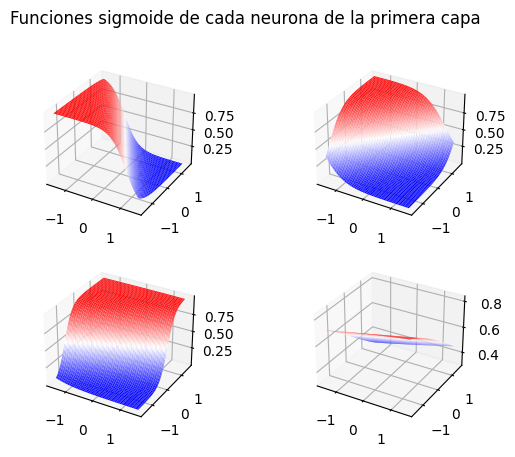

In [22]:
interval = np.linspace(-1.5, 1.5, 50)
xv, yv = np.meshgrid(interval, interval)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection='3d'))
plt.suptitle("Funciones sigmoide de cada neurona de la primera capa")

axes[0, 0].plot_surface(xv, yv, neurona1_capa1(xv, yv), edgecolor='none', cmap='bwr')
axes[0, 1].plot_surface(xv, yv, neurona2_capa1(xv, yv), edgecolor='none', cmap='bwr')
axes[1, 0].plot_surface(xv, yv, neurona3_capa1(xv, yv), edgecolor='none', cmap='bwr')
axes[1, 1].plot_surface(xv, yv, neurona4_capa1(xv, yv), edgecolor='none', cmap='bwr')
plt.show()


Con [tensorflow](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4&seed=0.73655&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)